In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Load the Dataset

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data/Text Preprocessing

In [3]:
df.replace({"sentiment" :{"positive":1,"negative":0}},inplace = True)

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

# Checking duplicated

In [6]:
df.duplicated().sum()

418

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.duplicated().sum()

0

In [9]:
df["review"] = df["review"].str.lower()

In [10]:
df.head(2)

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1


# Text cleaning

In [11]:
import re

def clean_text(text):
    # Remove URLs
    text_no_urls = re.sub(r'http\S+|www\.\S+', '', text, flags=re.IGNORECASE)
    # Remove symbols except letters, numbers, spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text_no_urls)
    return cleaned_text

df['review'] = df['review'].apply(clean_text)

In [12]:
df.head(2)

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1


# Stop word removal

In [13]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')# Download stopwords if not already done
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()  # simple split by whitespace
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df['review'] = df['review'].apply(remove_stopwords) # Apply to DataFrame column

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df.head(2)

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production br br filming tech...,1


# Split the data

In [15]:
from sklearn.model_selection import train_test_split

# Split data: 80% train, 20% test (you can adjust test_size)
train_data, test_data = train_test_split(df,test_size=0.2, random_state=42)

<Axes: >

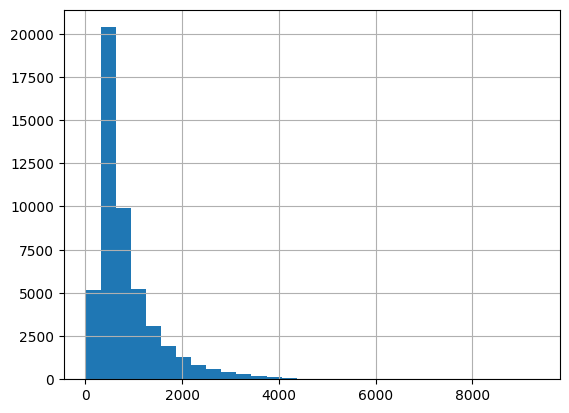

In [16]:
# analyze number of characters in reviews
df['review'].str.len().hist(bins=30)

# Tokienization and pad Sequences

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['review'])  # Fit tokenizer on texts

# Convert texts to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data['review'])
test_sequences = tokenizer.texts_to_sequences(test_data['review'])

# Pad sequences to the same length
x_train = pad_sequences(train_sequences, maxlen=200)
x_test = pad_sequences(test_sequences, maxlen=200)


2025-05-18 16:16:24.168280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747584984.447992      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747584984.522869      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Feature Engineering
**convert text data into numerical format using TF-IDF**

In [18]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
x = df['review']
y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression
## Model Training

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_tfidf)

# Model Evaluation

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8832308157708985


In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.87      0.90      0.89      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



# Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()

# Train the model on the TF-IDF transformed training data
nb_model.fit(X_train_tfidf, y_train)

y_pred = nb_model.predict(X_test_tfidf)

# Model Evaluation

In [23]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8475345366542301


In [ ]:
# Define a mapping from numeric labels to string labels
label_map = {0: "negative", 1: "positive"}

def predict_sentiment(review_text):
    # Transform the input review using TF-IDF vectorizer
    review_tfidf = tfidf.transform([review_text])
    
    # Predict sentiment (0 or 1)
    prediction = log_reg.predict(review_tfidf)[0]
    
    # Map numeric prediction to string label
    sentiment_label = label_map[prediction]
    
    return sentiment_label

if __name__ == "__main__":
    print("Sentiment Analysis Interface")
    print("Type 'exit' to quit.")
    
    while True:
        user_input = input("\nEnter a movie review: ")
        if user_input.lower() == 'exit':
            print("Exiting the sentiment analysis interface.")
            break
        
        sentiment = predict_sentiment(user_input)
        print(f"Predicted Sentiment: {sentiment}")

Sentiment Analysis Interface
Type 'exit' to quit.



Enter a movie review:  i like this movie ,best movie ever


Predicted Sentiment: positive



Enter a movie review:  movie was average


Predicted Sentiment: negative
